In [1]:
import tensorflow as tf
import numpy as np
import zipfile

In [2]:
val = zipfile.ZipFile('train.zip','r')
val.extractall('train')
val.close()

In [3]:
test = zipfile.ZipFile('testing.zip','r')
test.extractall('test')
test.close()

In [4]:
train = zipfile.ZipFile('validasi.zip','r')
train.extractall('val')
train.close()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Train
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.3,
        horizontal_flip=False)


train_generator = train_datagen.flow_from_directory(
    'train/train',
    target_size=(150,150),
    batch_size=32,
    class_mode = 'categorical'
)


# Validation
validation_datagen = ImageDataGenerator(rescale=1/255)

val_generator = validation_datagen.flow_from_directory(
    'val',
    target_size=(150,150),
    batch_size=32,
    class_mode = 'categorical'
)

Found 3780 images belonging to 18 classes.
Found 810 images belonging to 18 classes.


In [7]:
# # Remember to inherit from the correct class
# class myCallback(tf.keras.callbacks.Callback):
#         # Define the correct function signature for on_epoch_end
#         def on_epoch_end(self, epoch, logs={}):
#             if logs.get('accuracy') is not None and logs.get('accuracy') > 0.96:
#                 print("\nReached 96% accuracy so cancelling training!")

#                 # Stop training once the above condition is met
#                 self.model.stop_training = True

# ### END CODE HERE

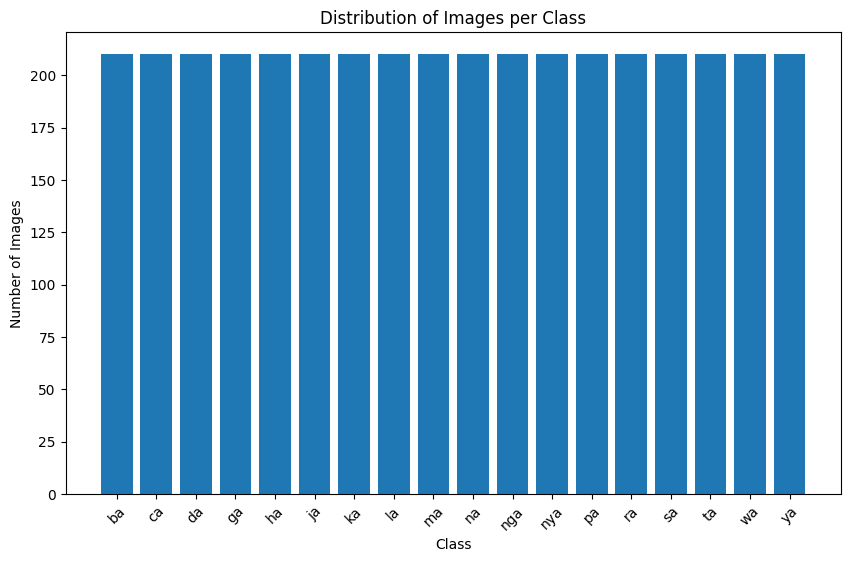

In [6]:
import matplotlib.pyplot as plt

class_labels = list(train_generator.class_indices.keys())

# Mendapatkan jumlah gambar dalam setiap kelas
class_counts = np.sum(train_generator.labels == np.arange(len(class_labels))[:, None], axis=1)

# Plot distribusi gambar
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=45)
plt.show()

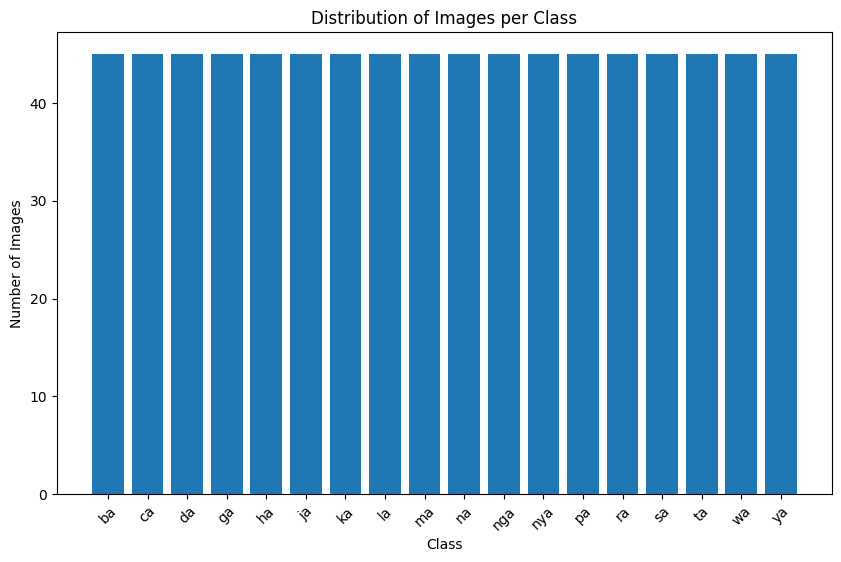

In [8]:
class_labels = list(val_generator.class_indices.keys())

# Mendapatkan jumlah gambar dalam setiap kelas
class_counts = np.sum(val_generator.labels == np.arange(len(class_labels))[:, None], axis=1)

# Plot distribusi gambar
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=45)
plt.show()

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150,3),
                                include_top=False,
                                weights='imagenet')


# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [10]:
last_layer = pre_trained_model.get_layer('mixed4')
last_output = last_layer.output

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (18, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
            validation_data=val_generator,
            epochs=20,
            verbose=1)

Epoch 1/20
119/119 [==============================] - 156s 1s/step - loss: 2.2693 - accuracy: 0.3362 - val_loss: 1.4395 - val_accuracy: 0.7519
Epoch 2/20
119/119 [==============================] - 170s 1s/step - loss: 1.2163 - accuracy: 0.7190 - val_loss: 0.7014 - val_accuracy: 0.8852
Epoch 3/20
119/119 [==============================] - 152s 1s/step - loss: 0.7441 - accuracy: 0.8296 - val_loss: 0.4741 - val_accuracy: 0.8889
Epoch 4/20
119/119 [==============================] - 162s 1s/step - loss: 0.5164 - accuracy: 0.8833 - val_loss: 0.2924 - val_accuracy: 0.9667
Epoch 5/20
119/119 [==============================] - 154s 1s/step - loss: 0.4081 - accuracy: 0.9066 - val_loss: 0.2521 - val_accuracy: 0.9370
Epoch 6/20
119/119 [==============================] - 151s 1s/step - loss: 0.3376 - accuracy: 0.9156 - val_loss: 0.1720 - val_accuracy: 0.9704
Epoch 7/20
119/119 [==============================] - 154s 1s/step - loss: 0.2910 - accuracy: 0.9291 - val_loss: 0.1820 - val_accuracy: 0.9556

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator untuk data pelatihan
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(150, 150),
    batch_size=32,  # Anda dapat menyesuaikan batch_size sesuai kebutuhan Anda
    class_mode='categorical',  # Pastikan class_mode sesuai dengan jenis klasifikasi Anda
    shuffle=False  # Set shuffle=False untuk menjaga urutan data tetap
)
from sklearn.metrics import classification_report
# Prediksi menggunakan model
predIdxs = model.predict(test_generator)

# Konversi prediksi ke label kelas
predIdxs = np.argmax(predIdxs, axis=1)

# Cetak laporan klasifikasi
print(classification_report(test_generator.classes, predIdxs, target_names=test_generator.class_indices.keys()))

Found 810 images belonging to 18 classes.
26/26 [==============================] - 24s 860ms/step
              precision    recall  f1-score   support

          ba       0.96      0.98      0.97        45
          ca       1.00      1.00      1.00        45
          da       1.00      1.00      1.00        45
          ga       0.92      1.00      0.96        45
          ha       1.00      1.00      1.00        45
          ja       1.00      1.00      1.00        45
          ka       1.00      0.98      0.99        45
          la       1.00      1.00      1.00        45
          ma       1.00      0.98      0.99        45
          na       1.00      1.00      1.00        45
         nga       1.00      0.98      0.99        45
         nya       0.98      0.93      0.95        45
          pa       1.00      0.98      0.99        45
          ra       1.00      1.00      1.00        45
          sa       1.00      1.00      1.00        45
          ta       0.98      1.00    

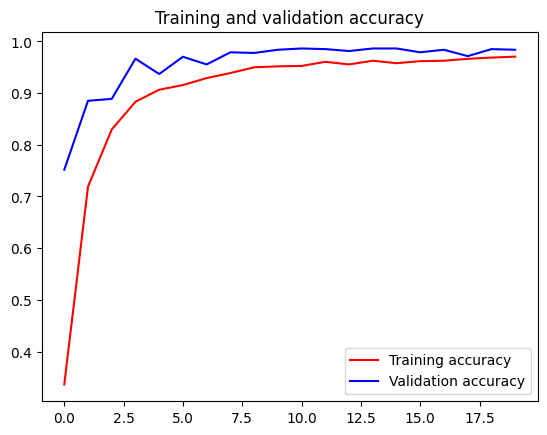

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

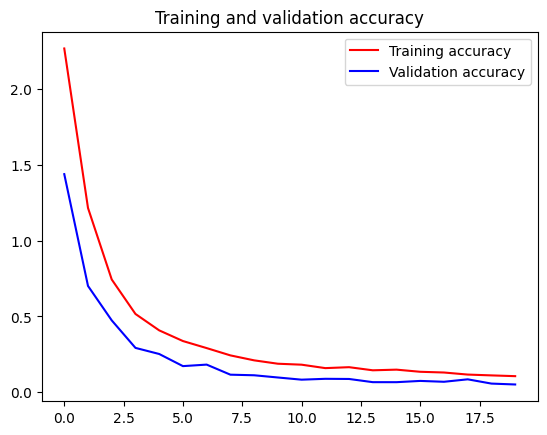

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
train_generator.classes

class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

Class Indices: {'ba': 0, 'ca': 1, 'da': 2, 'ga': 3, 'ha': 4, 'ja': 5, 'ka': 6, 'la': 7, 'ma': 8, 'na': 9, 'nga': 10, 'nya': 11, 'pa': 12, 'ra': 13, 'sa': 14, 'ta': 15, 'wa': 16, 'ya': 17}


#Test


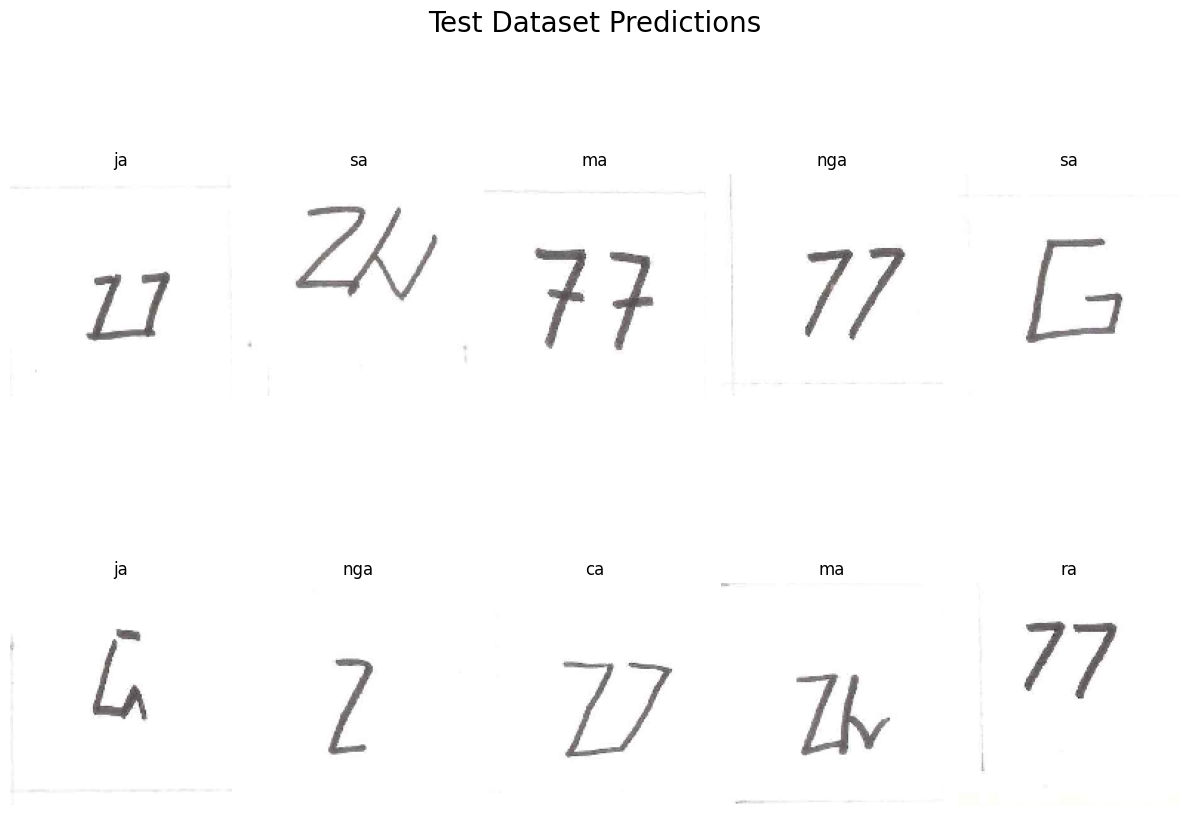

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(val_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(val_generator)

51/51 [==============================] - 52s 1s/step - loss: 0.0563 - accuracy: 0.9827


1/1 [==============================] - 2s 2s/step
Predicted class: ba
Prediction probabilities: [[9.9994254e-01 6.6133690e-01 9.6773148e-01 2.9502125e-03 2.5205648e-01
  3.6295019e-02 3.9507117e-04 5.6068164e-01 2.3420696e-01 4.2768399e-08
  3.0602249e-03 9.8750812e-01 5.9192270e-01 6.6095240e-06 2.5275457e-04
  2.1687413e-02 8.9389414e-01 1.7882210e-01]]


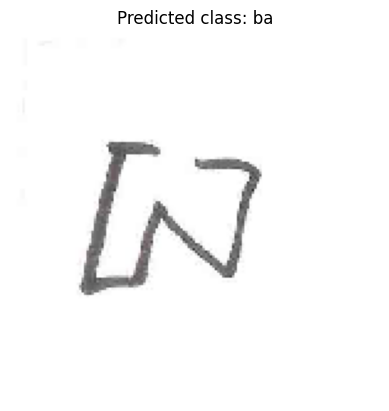

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Peta label ke indeks yang Anda miliki
class_indices = {'ba': 0, 'ca': 1, 'da': 2, 'ga': 3, 'ha': 4, 'ja': 5, 'ka': 6, 'la': 7, 'ma': 8, 'na': 9, 'nga': 10, 'nya': 11, 'pa': 12, 'ra': 13, 'sa': 14, 'ta': 15, 'wa': 16, 'ya': 17}

# Membalik dictionary untuk mendapatkan peta indeks ke nama kelas
indices_to_class = {v: k for k, v in class_indices.items()}

def load_and_preprocess_image(img_path, target_size=(150, 150)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the expected input shape of the model (1, 150, 150, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image (same preprocessing used for training data)
    img_array /= 255.0
    return img_array

def predict_new_image(model, img_path):
    # Preprocess the image
    processed_img = load_and_preprocess_image(img_path)
    # Make a prediction
    prediction = model.predict(processed_img)
    # Convert prediction to class label
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = indices_to_class[predicted_class_index]
    return predicted_class_label, prediction

# Path to your new image
img_path = 'test/ha/'

# Predict the class of the new image
predicted_label, prediction_probabilities = predict_new_image(model, img_path)
print(f"Predicted class: {predicted_label}")
print(f"Prediction probabilities: {prediction_probabilities}")

# Optional: Display the image and prediction result
img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
plt.title(f"Predicted class: {predicted_label}")
plt.axis('off')
plt.show()


In [16]:
from keras.models import load_model

# Simpan model ke dalam file .h5
model.save('sunda_aksara(mixed_4).h5')

# Kemudian Anda dapat memuat model dari file .h5 yang disimpan
# loaded_model = load_model('nama_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model("sunda_aksara(mixed_4).h5")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("aksara_sunda.tflite", "wb") as f:
    f.write(tflite_model)


OSError: No file or directory found at sunda_aksara(mixed_4).h5

In [ ]:
# !rm -rf latih
# !rm -rf pred
# !rm -rf testing
# !rm -rf testing3
!rm -rf train
!rm -rf test
!rm -rf val
# !rm -rf valid
# !rm -rf validasi
# !rm -rf validation